# Implementing Advantage-Actor Critic (A2C) - 4 pts

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames, stack them together, prepares for PyTorch and normalizes to [0, 1]) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function.

In [ ]:
!pip install gym==0.25.2
!pip install -U gym[atari,accept-rom-license]
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 20.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached libtorrent-2.0.7-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.0-py3-none-any.whl size=440868 sha256=6d31fead377d03c1af8d7d01a9332cfd048a67ed2ca3569ed9dc9ca062be808f
  Stored in directory: /root/.cache/pip/wheels/bf/c9/25/578470ae932b494c313dc22e6c57afff192140fb3cd5acf185
Successfully built AutoROM.accept-rom-license
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 14.2 MB/s 


In [ ]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [ ]:
import numpy as np
from atari_wrappers import nature_dqn_env

nenvs = 8    # change this if you have more than 8 CPU ;)

env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=nenvs)

n_actions = env.action_space.spaces[0].n
obs = env.reset()
assert obs.shape == (nenvs, 4, 84, 84)
assert obs.dtype == np.float32

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initial

Next, we will need to implement a model that predicts logits of policy distribution and critic value. Use shared backbone. You may use same architecture as in DQN task with one modification: instead of having a single output layer, it must have two output layers taking as input the output of the last hidden layer (one for actor, one for critic). 

Still it may be very helpful to make more changes:
* use orthogonal initialization with gain $\sqrt{2}$ and initialize biases with zeros;
* use more filters (e.g. 32-64-64 instead of 16-32-64);
* use two-layer heads for actor and critic or add a linear layer into backbone;

**Danger:** do not divide on 255, input is already normalized to [0, 1] in our wrappers!

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [ ]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

In [ ]:
import torch
import torch.nn as nn

class A2CNetwork(nn.Module):
    '''
    input:
        states - tensor, (batch_size x channels x width x height)
    output:
        logits - tensor, logits of action probabilities for your actor policy, (batch_size x num_actions)
        V - tensor, critic estimation, (batch_size)
    '''

    def __init__(self, state_shape, n_actions):

        super().__init__()
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        first_conv_size = 32
        second_conv_size = 64
        third_conv_size = 64
        kernel_size = 3
        stride = 2

        hidden_dense_size = state_shape[-1]
        for _ in range(3):
            hidden_dense_size = conv2d_size_out(hidden_dense_size, kernel_size, stride)
        dense_size = third_conv_size * hidden_dense_size ** 2

        self.agent = torch.nn.Sequential(
            torch.nn.Conv2d(state_shape[1], first_conv_size, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.Conv2d(first_conv_size, second_conv_size, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.Conv2d(second_conv_size, third_conv_size, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        
        # weights initialization
        for layer in self.agent.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.orthogonal_(layer.weight, gain=nn.init.calculate_gain('relu'))
                layer.bias.data.zero_()
        
        self.actor = torch.nn.Sequential(       
            torch.nn.Linear(dense_size, 2 * dense_size),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * dense_size, n_actions),
            torch.nn.ReLU()
        )
        
        self.critic =  torch.nn.Sequential(          
            torch.nn.Linear(dense_size, 2 * dense_size),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * dense_size, 1),
            torch.nn.ReLU()
        )

    def forward(self, state):

        conv_output = self.agent(state)

        return self.actor(conv_output), torch.squeeze(self.critic(conv_output))

You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a **dictionary** of all the arrays that are needed to interact with an environment and train the model.

**Important**: "actions" will be sent to environment, they must be numpy array or list, not PyTorch tensor.

Note: you can add more keys, e.g. it can be convenient to compute entropy right here.

In [ ]:
from torch.distributions import Categorical

class Policy:
    def __init__(self, model):
        self.model = model

    def act(self, inputs):
        '''
        input:
            inputs - numpy array, (batch_size x channels x width x height)
        output: dict containing keys ['actions', 'logits', 'log_probs', 'values']:
            'actions' - selected actions, numpy, (batch_size)
            'logits' - actions logits, tensor, (batch_size x num_actions)
            'log_probs' - log probs of selected actions, tensor, (batch_size)
            'values' - critic estimations, tensor, (batch_size)
        '''
        logits, v = self.model(torch.tensor(inputs, dtype=torch.float32))
        n_actions = logits.shape[-1]
        
        probs = np.array(nn.functional.softmax(logits, -1).detach())
        actions = np.array([np.random.choice(n_actions, p=prob) for prob in probs])
        
        log_probs = nn.functional.log_softmax(logits, -1)
        log_probs_actions = torch.sum(
            log_probs * nn.functional.one_hot(torch.tensor(actions,dtype=torch.int64), n_actions), 
            dim=1
        )
        
        entropy = -(log_probs.detach() * probs).sum(axis=1)
        
        return {
            "actions": actions,
            "logits": logits,
            "log_probs": log_probs_actions,
            "values": v,
            "entropy": entropy
        }

Next we will pass the environment and policy to a runner that collects rollouts from the environment. 
The class is already implemented for you.

In [ ]:
from runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'dones'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory, or rollout length. Let's have a look at how it works.

In [ ]:
model = A2CNetwork(obs.shape, n_actions)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=5)

In [ ]:
# generates new rollout
trajectory = runner.get_next()

In [ ]:
# what is inside
print(trajectory.keys())

dict_keys(['actions', 'logits', 'log_probs', 'values', 'entropy', 'observations', 'rewards', 'dones'])


In [ ]:
# Sanity checks
assert 'logits' in trajectory, "Not found: policy didn't provide logits"
assert 'log_probs' in trajectory, "Not found: policy didn't provide log_probs of selected actions"
assert 'values' in trajectory, "Not found: policy didn't provide critic estimations"
assert trajectory['logits'][0].shape == (nenvs, n_actions), "logits wrong shape"
assert trajectory['log_probs'][0].shape == (nenvs,), "log_probs wrong shape"
assert trajectory['values'][0].shape == (nenvs,), "values wrong shape"

for key in trajectory.keys():
    assert len(trajectory[key]) == 5, \
    f"something went wrong: 5 steps should have been done, got trajectory of length {len(trajectory[key])} for '{key}'"

Now let's work with this trajectory a bit. To train the critic you will need to compute the value targets. It will also be used as an estimation of $Q$ for actor training.

You should use all available rewards for value targets, so the formula for the value targets is simple:

$$
\hat v(s_t) = \sum_{t'=0}^{T - 1}\gamma^{t'}r_{t+t'} + \gamma^T \hat{v}(s_{t+T}),
$$

where $s_{t + T}$ is the latest observation of the environment.

Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 

**Do not forget** to use `trajectory['dones']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step.

**Bonus (+1 pt):** implement [Generalized Advantage Estimation (GAE)](https://arxiv.org/pdf/1506.02438.pdf) instead; use $\lambda \approx 0.95$ or even closer to 1 in experiment. 

In [ ]:
class ComputeValueTargets:
    def __init__(self, policy, gamma=0.99):
        self.policy = policy
        self.gamma = gamma

    def __call__(self, trajectory, latest_observation):
        '''
        This method should modify trajectory inplace by adding 
        an item with key 'value_targets' to it
        
        input:
            trajectory - dict from runner
            latest_observation - last state, numpy, (num_envs x channels x width x height)
        '''

        with torch.no_grad():
            n_steps = len(trajectory['actions'])
            rewards = trajectory['rewards']
            dones = trajectory['dones']
            next_val = self.policy.act(latest_observation)['values'].detach().numpy()      
            returns = np.vstack([rewards, next_val])
            for env in range(latest_observation.shape[0]):
                for step in range(n_steps-1, -1, -1):
                    returns[step][env] += self.gamma * returns[step + 1][env] * (1 - dones[step][env])
            trajectory['value_targets'] = torch.Tensor(returns[:-1])
        

After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`.

You need to make sure that after this transformation `"log_probs"`, `"value_targets"`, `"values"` are 1-dimensional PyTorch tensors.

In [ ]:
class MergeTimeBatch:
    """ Merges first two axes typically representing time and env batch. """
    def __call__(self, trajectory, latest_observation):
        # Modify trajectory inplace. 
        for key in ['logits', 'log_probs', 'values', 'entropy']:
            shapes = torch.stack(trajectory[key]).shape
            dim = shapes[0] * shapes[1]
            trajectory[key] = torch.stack(trajectory[key]).reshape(dim, -1).squeeze()
        trajectory['value_targets'] = trajectory['value_targets'].reshape(dim, -1).squeeze()

Let's do more sanity checks!

In [ ]:
runner = EnvRunner(env, policy, nsteps=5, transforms=[ComputeValueTargets(policy),
                                                      MergeTimeBatch()])

trajectory = runner.get_next()

In [ ]:
# More sanity checks
assert 'value_targets' in trajectory, "Value targets not found"
assert trajectory['log_probs'].shape == (5 * nenvs,)
assert trajectory['value_targets'].shape == (5 * nenvs,)
assert trajectory['values'].shape == (5 * nenvs,)

assert trajectory['log_probs'].requires_grad, "Gradients are not available for actor head!"
assert trajectory['values'].requires_grad, "Gradients are not available for critic head!"

Now is the time to implement the advantage actor critic algorithm itself. You can look into [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and lectures ([part 1](https://www.youtube.com/watch?v=Ds1trXd6pos&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=5), [part 2](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=6)) by Sergey Levine.

# Actor-critic objective

Here we define a loss function that uses rollout above to train advantage actor-critic agent.


Our loss consists of three components:

* __The policy "loss"__
 $$ \hat{J}_{policy} = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * This function has no meaning in and of itself, but it was built such that
  * $ \nabla \hat J_{policy} = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * Therefore if we __maximize__ $\hat{J}_{policy}$ with gradient ascent we will maximize expected reward
  
  
* __The value "loss"__
  $$ L_{value} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Old good TD-loss from q-learning and alike
  * If we minimize this loss, $V(s)$ will converge to $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $
  * Note that target can be N-step in the same way as $A(s,a)$


* __Entropy Regularizer__
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * If we __maximize__ entropy we discourage agent from predicting zero probability to actions
  prematurely (a.k.a. exploration)
  
  
So we optimize a linear combination of $L_{value} - \hat J_{policy} -H$
  
```

```

```

```

```

```


__One more thing:__ since we train on T-step rollouts, we can use N-step formula for advantage for free:
  * At the last step, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s_t) $
  * One step earlier, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s_t) $
  * Et cetera, et cetera. This way agent starts training much faster since it's estimate of A(s,a) depends less on his (imperfect) value function and more on actual rewards. There's also a [nice generalization](https://arxiv.org/abs/1506.02438) of this.


In [ ]:
from collections import defaultdict
from torch.nn.utils import clip_grad_norm_

class A2C:
    def __init__(self, policy, optimizer, value_loss_coef=0.25, entropy_coef=0.01, max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.logs = {
            'policy_loss': [], 
            'critic_loss': [],
            'actor_loss': [],
            'entropy': [],
            'grad_norm': [],
            # 'reward': []
        }
    
    def loss(self, trajectory, write):
        # compute all losses
        # do not forget to use weights for critic loss and entropy loss
        advantage = trajectory['value_targets'] - trajectory['values']
        actor_loss = - trajectory['log_probs'] * advantage
        critic_loss = advantage ** 2
        entropy_loss = - trajectory['entropy']
        policy_loss = actor_loss + critic_loss * self.value_loss_coef + entropy_loss * self.entropy_coef
        # rewards = trajectory['rewards']
        
        # log all losses
        write('losses', {
            'policy loss': policy_loss.mean(),
            'critic loss': critic_loss.mean(),
            'entropy loss': entropy_loss.mean()
        })
        
        # additional logs
        write('critic/advantage', advantage.mean())
        write('critic/values', {
            'value predictions': trajectory['values'].mean(),
            'value targets': trajectory['value_targets'].mean(),
        })

        self.logs['policy_loss'].append(policy_loss.mean())
        self.logs['critic_loss'].append(critic_loss.mean())
        self.logs['actor_loss'].append(actor_loss.mean())
        self.logs['entropy'].append(entropy_loss.mean())
        # self.logs['reward'].append(rewards.mean())

        # return scalar loss
        return policy_loss.mean()              

    def train(self, runner):
        # collect trajectory using runner
        # compute loss and perform one step of gradient optimization
        # do not forget to clip gradients
        trajectory = runner.get_next()
        loss = self.loss(trajectory, write)
        loss.backward()
        self.optimizer.step()
        grad_norm = clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.zero_grad()
        
        # use runner.write to log scalar to tensorboard
        runner.write('gradient norm', grad_norm)
        self.logs['grad_norm'].append(grad_norm)

Now you can train your model. For optimization we suggest you use RMSProp with learning rate 7e-4 (you can also linearly decay it to 0), smoothing constant (alpha in PyTorch) equal to 0.99 and epsilon equal to 1e-5.

We recommend to train for at least 10 million environment steps across all batched environments (takes ~3 hours on a single GTX1080 with 8 CPU). It should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last episodes in each environment in the batch) of about 600. **Your goal is to reach 500**.

Notes:
* if your reward is stuck at ~200 for more than 2M steps then probably there is a bug
* if your gradient norm is >10 something probably went wrong
* make sure your `entropy loss` is negative, your `critic loss` is positive
* make sure you didn't forget `.detach` in losses where it's needed
* `actor loss` should oscillate around zero or near it; do not expect loss to decrease in RL ;)
* you can experiment with `nsteps` ("rollout length"); standard rollout length is 5 or 10. Note that this parameter influences how many algorithm iterations is required to train on 10M steps (or 40M frames --- we used frameskip in preprocessing).

In [ ]:
import random

seed = 19
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
state_shape = obs.shape

model = A2CNetwork(state_shape, n_actions)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=10, transforms=[ComputeValueTargets(policy),
                                                      MergeTimeBatch()])

optimizer = torch.optim.RMSprop(policy.model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5, weight_decay=0, momentum=0, centered=False)

a2c = A2C(policy, optimizer)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
write = SummaryWriter

In [ ]:
# %tensorboard --logdir losses
# Почему-то не работает тензорборд

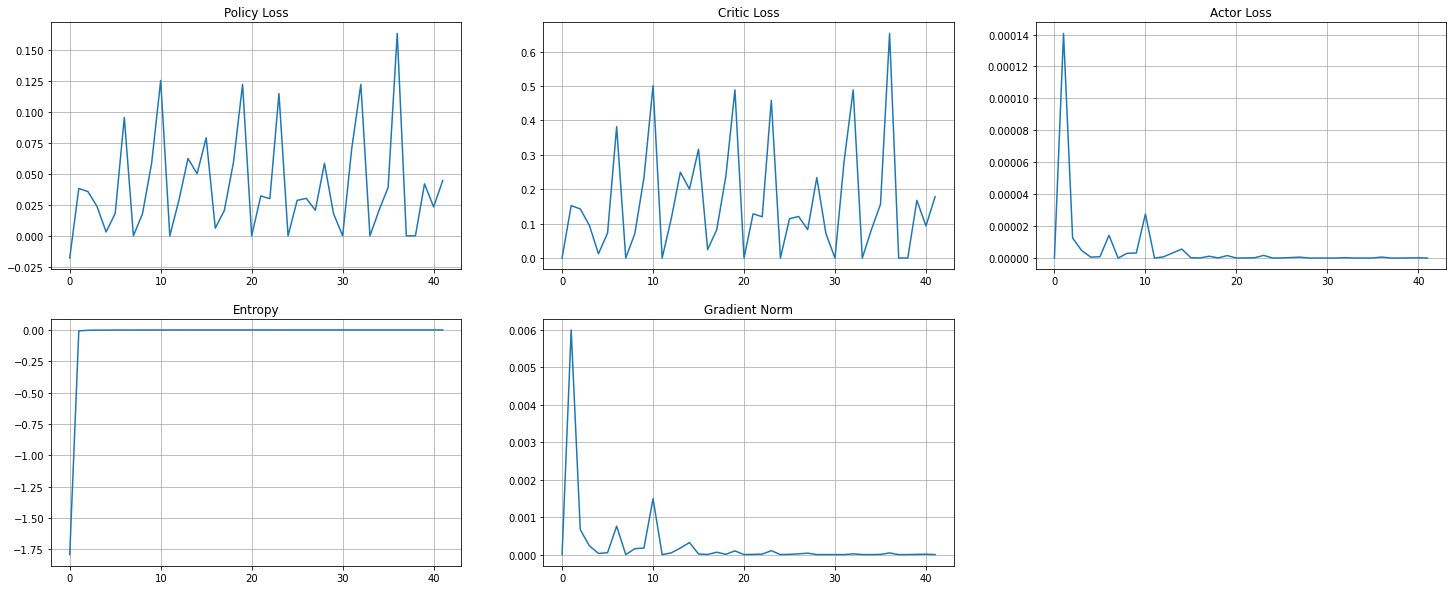

 42%|████▏     | 2100/5000 [3:09:10<4:21:14,  5.41s/it]


KeyboardInterrupt: ignored

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

n_epoch = 5000
counter = 0
interval = 50

for i in tqdm(range(n_epoch)):
    a2c.train(runner)
    counter += 1
    
    if counter == interval:
        counter = 0
        clear_output(True)

        plt.figure(figsize=[25, 10])
        n_rec = len(a2c.logs['policy_loss'])

        for j, key in enumerate(['policy_loss', 'critic_loss', 'actor_loss', 'entropy', 'grad_norm'], 1):
            plt.subplot(2, 3, j)
            plt.title(key)
            x = [a2c.logs[key][k].detach().numpy().tolist() for k in range(n_rec) if (k % interval == 0)]
            plt.plot(x)
            plt.grid()
        plt.show()
    if i % 500 == 0:
        torch.save(model.state_dict(), f"drive/MyDrive/A2C_{i}_epochs")

In [ ]:
# save your model just in case 
torch.save(model.state_dict(), "A2C") 

In [ ]:
env.close()

BrokenPipeError: ignored

## Evaluation

In [ ]:
env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, 
                     clip_reward=False, summaries=False, episodic_life=False)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def evaluate(env, policy, n_games=1, t_max=10000):
    '''
    Plays n_games and returns rewards
    '''
    rewards = []
    
    for _ in range(n_games):
        s = env.reset()
        
        R = 0
        for _ in range(t_max):
            action = policy.act(np.array([s]))["actions"][0]
            
            s, r, done, _ = env.step(action)
            
            R += r
            if done:
                break

        rewards.append(R)
    return np.array(rewards)

In [ ]:
# evaluation will take some time!
sessions = evaluate(env, policy, n_games=30)
score = sessions.mean()
print(f"Your score: {score}")

assert score >= 500, "Needs more training?"
print("Well done!")

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Your score: 285.0


AssertionError: ignored

Пробовал обучать на большем размере (менял 8 на 16 и 32), скор примерно 130 после 4 часов обучения. Засылаю лучший вариант.

In [ ]:
env.close()

## Record

In [ ]:
env_monitor = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=None, monitor=True,
                             clip_reward=False, summaries=False, episodic_life=False)

In [ ]:
# record sessions
sessions = evaluate(env_monitor, policy, n_games=3)

In [ ]:
# rewards for recorded games
sessions

In [ ]:
env_monitor.close()